In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import random
import ntpath

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

In [2]:
datadir = 'Data Collected'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names=columns)
pd.set_option('display.max_colwidth', None)

In [3]:
def data_plot(data, x_label, y_label):
    plt.bar(bins[:-1], hist, width=0.05)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
    return

In [4]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

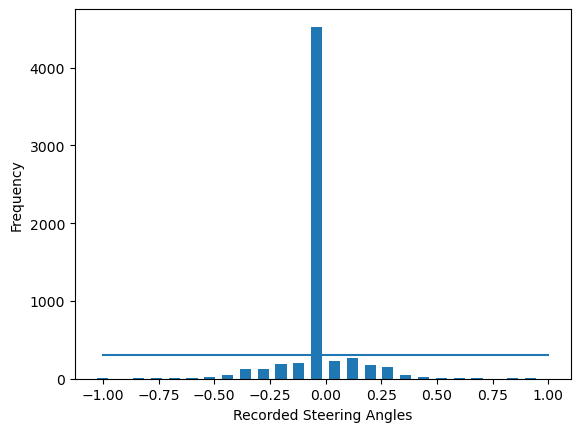

In [5]:
num_bins = 25
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
samples_per_bin = 300

data_plot(data, x_label='Recorded Steering Angles', y_label='Frequency')


total data:  6191


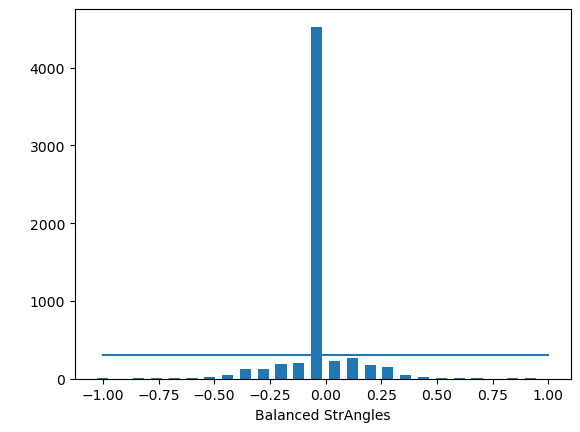

In [6]:
print('total data: ', len(data))
remove_list = []
for bin in range(num_bins):
    lst = []
    for str_ang in range(len(data['steering'])):
        if data['steering'][str_ang] >= bins[bin] and data['steering'][str_ang] <= bins[bin + 1]:
            lst.append(str_ang)
    lst = shuffle(lst)
    lst = lst[samples_per_bin:]
    remove_list.extend(lst)

data.drop(data.index[remove_list], inplace=True)

data_plot(data, x_label='Balanced StrAngles',y_label=' ')


In [7]:
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        center, left, right = data.iloc[i][0], data.iloc[i][1], data.iloc[i][2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(data.iloc[i][3]))
    return np.asarray(image_path), np.asarray(steering)

image_paths, steerings = load_img_steering(datadir + '/IMG', data)


C:\Users\3omd4\AppData\Local\Temp\ipykernel_37028\3817689846.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center, left, right = data.iloc[i][0], data.iloc[i][1], data.iloc[i][2]
C:\Users\3omd4\AppData\Local\Temp\ipykernel_37028\3817689846.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering.append(float(data.iloc[i][3]))


In [8]:
image_paths, steerings = load_img_steering(datadir + '/IMG', data)
x_train, x_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training samples: {}\nValidation samples: {}'.format(len(x_train), len(x_valid)))

C:\Users\3omd4\AppData\Local\Temp\ipykernel_37028\3817689846.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center, left, right = data.iloc[i][0], data.iloc[i][1], data.iloc[i][2]
C:\Users\3omd4\AppData\Local\Temp\ipykernel_37028\3817689846.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering.append(float(data.iloc[i][3]))


Training samples: 1572
Validation samples: 393


Text(0.5, 1.0, 'Validation set')

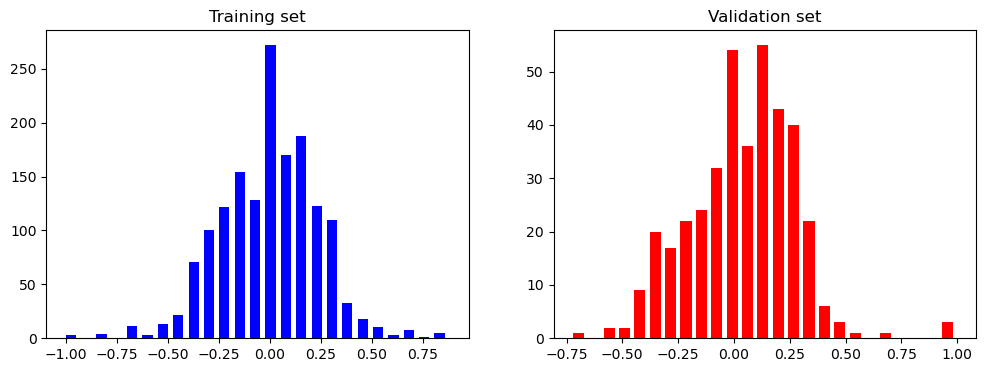

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [10]:
def img_preprocess(img):
    img = mpimg.imread(img)
    img = img[55:130, :, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img / 255
    return img

Text(0.5, 1.0, 'Preprocessed Image')

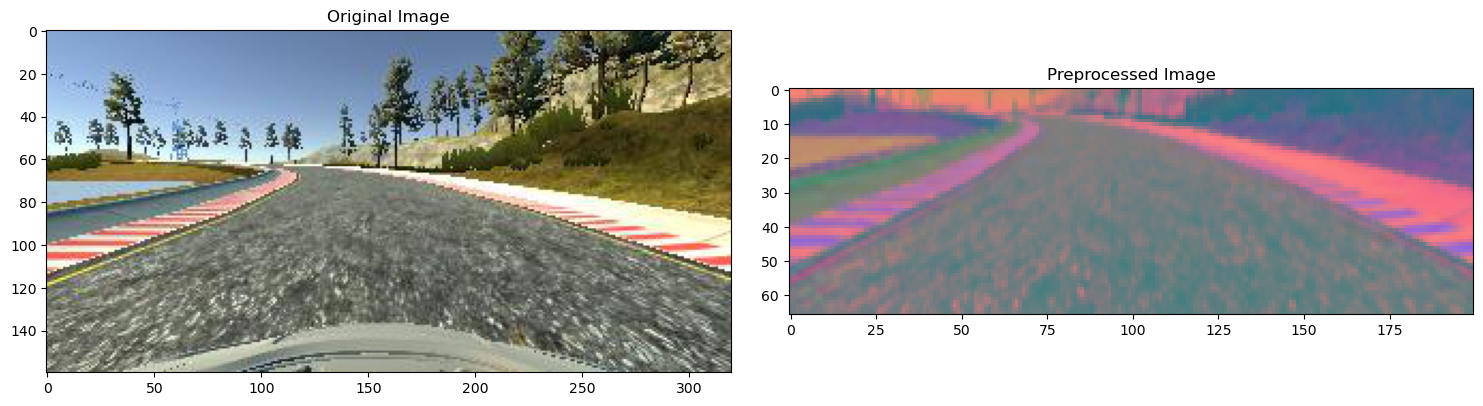

In [11]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)  
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')

In [12]:
x_train = np.array(list(map(img_preprocess, x_train)))
x_valid = np.array(list(map(img_preprocess, x_valid)))

(1572, 66, 200, 3)


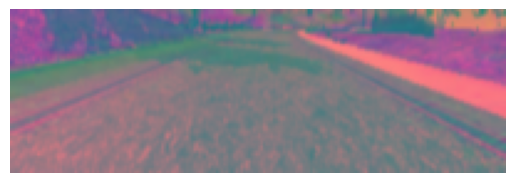

In [13]:
plt.imshow(x_train[random.randint(0, len(x_train)-1)])
plt.axis('off')
print(x_train.shape)

In [14]:
def nvidia_model():
    model = Sequential()
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(64, (3, 3), activation='elu'))
    model.add(Conv2D(64, (3, 3), activation='elu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [15]:
model = nvidia_model()
history = model.fit(x_train, y_train, epochs=30, validation_data=(x_valid, y_valid), batch_size=100, verbose=1, shuffle=1)
model.save('model.h5')
print(model.summary())

c:\Users\3omd4\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 1.7049 - val_loss: 0.1108
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.2431 - val_loss: 0.0411
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.1003 - val_loss: 0.0393
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0771 - val_loss: 0.0396
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0730 - val_loss: 0.0428
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0705 - val_loss: 0.0381
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0584 - val_loss: 0.0395
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0647 - val_loss: 0.0399
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0659 - val_loss: 0.0356
Epoch 10/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0564 - val_loss: 0.0335
Epoch 11/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0526 - val_loss: 0.0328
Epoch 12/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 31, 98, 24)     │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 47, 36)     │        21,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 22, 48)      │        43,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 20, 64)      │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 18, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 18, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       115,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 756,659 (2.89 MB)

 Trainable params: 252,219 (985.23 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 504,440 (1.92 MB)

None


Text(0.5, 0, 'Epoch')

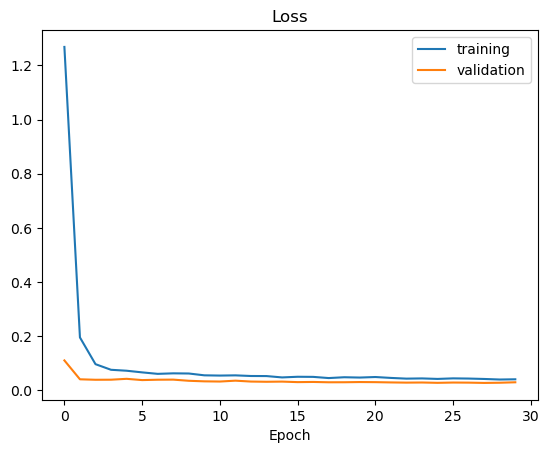

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [17]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [18]:
import tensorflow as tf
print("Keras version:", tf.keras.__version__)

Keras version: 3.8.0
